In [ ]:
!pip install tqdm
!pip install wfdb
!pip install utils
!pip install -U matplotlib

In [ ]:
import os
import h5py
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal as ss
import utils
from matplotlib import pyplot as plt

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
wf.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

In [ ]:
# these commands were used to fix an error "cannot import name '_png' from 'matplotlib'"
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
FILE=1
CHANNEL=0
SAMPLE_START=114000
SAMPLE_SIZE=4000

In [ ]:
# the code and the comments were taken from
# https://github.com/koen-aerts/ECG_ML/blob/master/01_view_mitdb_data.ipynb

record = wf.rdsamp('mitdb/100')
annotation = wf.rdann('mitdb/100', 'atr')
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

# Get data and annotations for the samples selected below.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Plot the heart beats. Time scale is number of readings
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# Extract annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Annotation codes.
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.rcParams.update({'font.size': 22})
plt.show()


In [ ]:
# the code and the comments were taken from
# https://github.com/koen-aerts/ECG_ML/blob/master/01_view_mitdb_data.ipynb


# assign directory
directory = "mitdb"

records = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        records.append(f)
print(len(records))

In [ ]:
!pip install biosppy
from scipy import signal
from biosppy.signals import ecg

In [ ]:
# most of the code and the comments were taken from
# https://github.com/koen-aerts/ECG_ML/blob/master/02_import_mitdb_data.ipynb
# except the classification distribution part


realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

classification_array = ['N', 'S', 'V', 'F', 'Q']

# Loop through each input file. Each file contains one
# record of ECG readings, sampled at 360 readings per
# second.
for path in records:
    pathpts = path.split('.')
    just_for_fn = pathpts[0].split('/')
    fn = just_for_fn[-1]
    print(fn)
    print(just_for_fn)
    print('Loading file:', path)

    # Read in the data
    record = wf.rdsamp(pathpts[0])
    annotation = wf.rdann(pathpts[0], 'atr')


     # Print some meta informations
    print('    Sampling frequency used for this record:', record[1].get('fs'))
    print('    Shape of loaded data array:', record[0].shape)
    print('    Number of loaded annotations:', len(annotation.num))

     # Get the ECG values from the file.
    data = record[0].transpose()

    # Generate the classifications based on the annotations.
    # The classifications are based on the paper by Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh
    cat = np.array(annotation.symbol)
    rate = np.zeros_like(cat, dtype='float')
    for catid, catval in enumerate(cat):
        if (catval == 'N' or catval == 'L' or catval == 'R' or catval == 'B' or catval == 'e' or catval == 'j' or catval == 'n'):
            rate[catid] = 1.0 # N
        if (catval == 'S' or catval == 'A' or catval == 'a' or catval == 'J'):
            rate[catid] = 2.0 # S
        if (catval == 'V' or catval == 'E' or catval == 'r'):
            rate[catid] = 3.0 # V
        if (catval == 'F'):
            rate[catid] = 4.0 # F
        if (catval == 'Q' or catval == '/' or catval == 'f'):
            rate[catid] = 5.0 # Q

    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate

    indices = np.arange(data[0].size, dtype='int')

    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)

        # Find rpeaks in the ECG data. Most should match with
        # the annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        beatstoremove = np.array([0])

        # Split into individual heartbeats. For each heartbeat
        # record, append classification.
        beats = np.split(channel, out['rpeaks'])
        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()

            # Skip beat if there is no classification.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], catval)

        beatstoremove = np.append(beatstoremove, len(beats)-1)

        # Remove first and last beats and the ones without classification.
        beats = np.delete(beats, beatstoremove)

        # Save to CSV file.
        savedata = np.array(list(beats[:]), dtype=np.float)
        outfn = "ECG_csvs/"+fn+'_'+chname+'.csv'
        print('    Generating ', outfn)

        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')


In [ ]:
# the idea was taken from
# https://github.com/koen-aerts/ECG_ML/blob/master/03_view_imported_data.ipynb

import numpy as np
import matplotlib

from matplotlib import pyplot as plt

data = np.loadtxt('ECG_csvs/210_MLII.csv', delimiter=',')
print(data.shape)

for beatid in [0,63,369]:
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    plt.plot(times, beat, 'b')
    plt.xlabel('Time [s]')
    plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
    plt.show()

In [ ]:
from glob import glob
import numpy as np

In [ ]:
# the code was taken from:
# https://github.com/koen-aerts/ECG_ML/blob/master/04_prep_imported_data.ipynb

alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob('ECG_csvs/*.csv')
for path in paths:
    print('Loading ', path)
    csvrows = np.loadtxt(path, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)

In [ ]:
print(alldata.shape)

In [ ]:
# the idea is taken from:
# https://github.com/koen-aerts/ECG_ML/blob/master/04_prep_imported_data.ipynb

np.random.shuffle(alldata)
totrows = len(alldata)
trainrows = int((totrows * 4 / 5) + 0.5) # 80%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
mark1 = trainrows
mark2 = mark1 + testrows

In [ ]:
# the code was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

with open('train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')
with open('test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight, resample

In [ ]:
# the commands to read the train and test sets

train_df = pd.read_csv('train.csv',header=None)
test_df = pd.read_csv('test.csv',header=None)

In [ ]:
clases = train_df[187].value_counts()
print(clases)
clases = test_df[187].value_counts()
print(clases)

0.0    103097
4.0      9098
2.0      3892
1.0      2745
3.0       654
Name: 187, dtype: int64
0.0    25763
4.0     2295
2.0     1005
1.0      643
3.0      166
Name: 187, dtype: int64


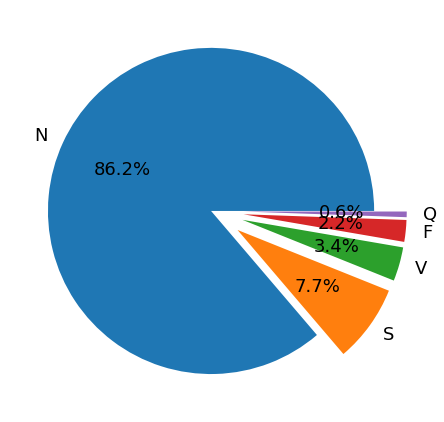

In [ ]:
# the code was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

plt.figure(figsize=(7.5,7.5))
explode = (0, 0.2, 0.2, 0.2, 0.2)
plt.pie(clases, labels=['N','S','V','F','Q'], autopct='%1.1f%%', explode=explode)
plt.rcParams.update({'font.size': 18})
plt.show()

In [ ]:
# the code was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

df_0 = train_df[train_df[187]==0.0].sample(n=20000, random_state=1)
df_1 = train_df[train_df[187]==1.0]
df_2 = train_df[train_df[187]==2.0]
df_3 = train_df[train_df[187]==3.0]
df_4 = train_df[train_df[187]==4.0]

df_1_up=resample(df_1, replace=True, n_samples=20000, random_state=1)
df_2_up=resample(df_2, replace=True, n_samples=20000, random_state=1)
df_3_up=resample(df_3, replace=True, n_samples=20000, random_state=1)
df_4_up=resample(df_4, replace=True, n_samples=20000, random_state=1)

train_df = pd.concat([df_0, df_1_up, df_2_up, df_3_up, df_4_up])

0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: 187, dtype: int64


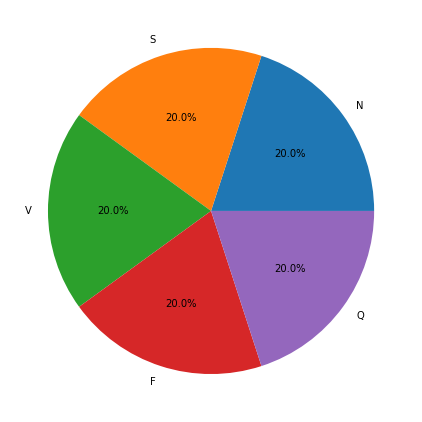

In [ ]:
# the code was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

clases = train_df[187].value_counts()
print(clases)

plt.figure(figsize=(7.5,7.5))
plt.pie(clases, labels=['N','S','V','F','Q'], autopct='%1.1f%%')
plt.show()

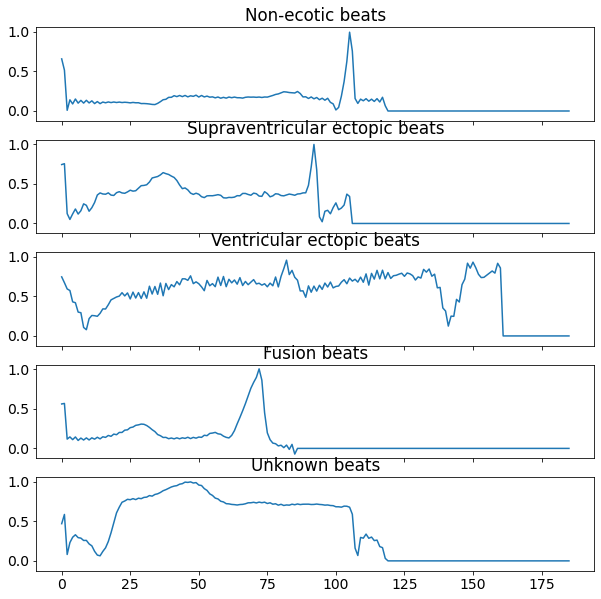

In [ ]:
# the code was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

sample_n=df_0.sample(1)
sample_s=df_1.sample(1)
sample_v=df_2.sample(1)
sample_f=df_3.sample(1)
sample_q=df_4.sample(1)

fig, ax = plt.subplots(5, sharex=True, sharey=True)
fig.set_size_inches(10,10)
ax[0].plot(sample_n.iloc[0,:186])
ax[0].set_title("Non-ecotic beats")
ax[1].plot(sample_s.iloc[0,:186])
ax[1].set_title("Supraventricular ectopic beats")
ax[2].plot(sample_v.iloc[0,:186])
ax[2].set_title("Ventricular ectopic beats")
ax[3].plot(sample_f.iloc[0,:186])
ax[3].set_title("Fusion beats")
ax[4].plot(sample_q.iloc[0,:186])
ax[4].set_title("Unknown beats")
plt.rcParams.update({'font.size': 12})

plt.show()

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/mosheyerachmiel/ecg-classification/notebook

train1_df, val1_df = train_test_split(train_df, train_size=.8)

for temp_df in [train1_df, val1_df, test_df]:
  print(temp_df.shape[0], temp_df.shape[0]/train_df.shape[0])
  print(temp_df.iloc[:, -1].value_counts(normalize = True))
  print('\n')


In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

y_train = to_categorical(train1_df[187])
y_test = to_categorical(test_df[187])
y_val = to_categorical(val1_df[187])

x_train = train1_df.iloc[:,:186].values
x_test = test_df.iloc[:,:186].values
x_val = val1_df.iloc[:,:186].values

x_train = x_train.reshape(len(x_train), x_train.shape[1],1)
x_test = x_test.reshape(len(x_test), x_test.shape[1],1)
x_val = x_val.reshape(len(x_val), x_val.shape[1],1)


In [ ]:
from keras.layers import Conv1D, AveragePooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Our model architecture

network = Sequential()
network.add(Conv1D(64, 5, activation = "relu", input_shape = (x_train.shape[1], 1)))
network.add(AveragePooling1D(pool_size = 2))
network.add(Flatten())
network.add(Dense(units = 64, activation = "relu"))
network.add(Dropout(0.5))
network.add(Dense(units = 32, activation = "relu"))
network.add(Dense(5, activation = "softmax"))

network.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='./best_weights.h5', monitor='val_loss', save_best_only=True)]
network.summary()

NameError: ignored

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation/notebook

def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs = 25,  batch_size=32):
  results = network.fit(t_x, t_y, steps_per_epoch=2500, epochs=epochs, callbacks=callbacks, batch_size=batch_size, verbose = 1, validation_split = 0.1)
  print("Val Score: ", network.evaluate(val_x, val_y))
  return results

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation/notebook

n_folds = 5

model_history = []

for i in range(n_folds):
  print("Training on fold: ", i+1)
  t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size = 0.1)
  model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y))
  print("======="*12, end="\n\n\n")

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation/notebook

plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
from keras.models import  load_model
model = load_model('best_weights.h5')

In [ ]:
# the commands to evaluate the model based on the validation and test sets

model.evaluate(x_val, y_val)
model.evaluate(x_test, y_test)

934/934 [==============================] - 3s 3ms/step - loss: 0.1611 - accuracy: 0.9604


[0.16105443239212036, 0.9603977203369141]

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

class_names = ['N', 'S', 'V', 'F', 'Q']

scores = model.evaluate(x_test,y_test, verbose=1)
y_predict = model.predict(x_test)

cf_matrix = confusion_matrix(y_test.argmax(axis=1),y_predict.argmax(axis=1))


934/934 [==============================] - 3s 3ms/step - loss: 0.1611 - accuracy: 0.9604


In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


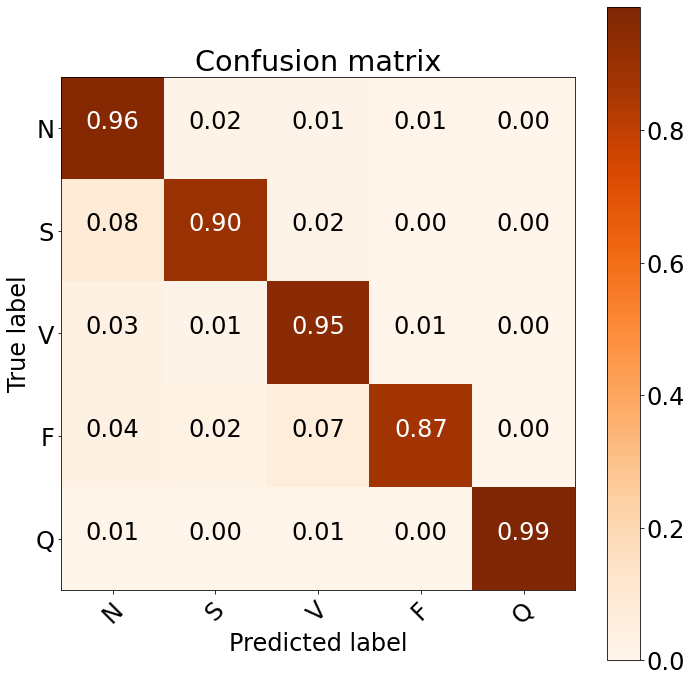

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/cristianbran/cnn-ecg-classification

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,title='Confusion matrix')
plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
# the idea was taken from
# https://www.kaggle.com/code/noorulhassanjutt/ecg-heartbeat-cnn

from sklearn.metrics import classification_report

Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     25763
           1       0.57      0.90      0.70       643
           2       0.69      0.95      0.80      1005
           3       0.50      0.87      0.63       166
           4       0.97      0.99      0.98      2295

    accuracy                           0.96     29872
   macro avg       0.75      0.93      0.82     29872
weighted avg       0.97      0.96      0.96     29872

